# Today you are a Data Scientist at Tesla! 
## You have assigned a new project to look at car sales from Quarters 1-2 in California for 2019 to make predictions as to which cars will be sold more than the others in Q3 and Q4, to ensure enough inventory to meet demands!

### If running this notebook in Google Colab, run the following cells first. Make sure you've placed the Q12 and Q34 sales data in the same Google Drive folder as this notebook.

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Replace the ID with ID of file you want to access. To get this ID: 

1.   Right-click on the name of the appropriate file in your Google Drive
2.   Click "Get link"
3.   Copy the characters between `d/` and the following slash
4.   Paste them into the dictionary argument of the call to `drive.CreateFile()` as the value associated with the 'id' key. Make sure that this value is a string.



In [3]:
# Replace the ID with ID of file you want to access
Q12 = drive.CreateFile({'id':'11o_b5worLqnvco1MdqRY52i0yz6UYmad'}) 
Q12.GetContentFile('sales_Q12_2019.csv') 
Q34 = drive.CreateFile({'id':'1SfWWRiWfZW2ac9Izk48IyV4RxMakD4ao'}) 
Q34.GetContentFile('sales_Q34_2019.csv') 

### Import the necessary modules

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Read in the CSV file containing the California sales data for Quarters 1 and 2

Then examine the data's shape and first few rows

In [5]:
df_sales = pd.read_csv("sales_Q12_2019.csv")
print(df_sales.shape)
df_sales.head()

(5837, 76)


,main_S60_1,main_S60_2,main_type_SP100D,main_type_S60D_1,main_type_S60D_2,main_type_S70,main_type_S70D,main_type_S75,main_type_S75D,main_type_S80,main_type_S80D,main_type_S85,main_type_S85P,main_type_P85D,main_type_S90,main_type_S90D,main_type_S100D,engine_A,engine_B,engine_C,engine_D,engine_E,engine_F,engine_G,engine_H,engine_I,engine_J,engine_K,engine_L,engine_M,engine_N,engine_O,engine_P,engine_Q,engine_R,engine_S,engine_T,engine_U,engine_V,engine_W,engine_X,engine_Y,engine_Z,sales_1,sales_2,sales_3,sales_4,sales_5,sales_6,sales_7,sales_8,sales_9,sales_10,sales_11,sales_12,sales_13,sales_14,sales_15,sales_16,sales_17,sales_18,sales_19,sales_20,sales_21,sales_22,sales_23,sales_24,sales_25,sales_26,sales_27,sales_28,sales_29,sales_30,MSRP,dealer_state,date
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44610,California,2019-04-28
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41505,California,2019-03-14
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,58890,California,2019-06-12
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51055,California,2019-03-04
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,70830,California,2019-01-23


### Begin cleaning the data

Eliminate the `'dealer_state'` and `'date'` columns. The former is useless to our model, since we already know that our dataset is restricted to California sales. While we could possibly extract useful information from the `'date'` column (for example, to determine whether more cars are sold on weekends than weekdays), we'll be focusing on car configurations in this exercise.

In [6]:
df_sales = df_sales.drop(columns=['dealer_state','date'])
df_sales.head()

,main_S60_1,main_S60_2,main_type_SP100D,main_type_S60D_1,main_type_S60D_2,main_type_S70,main_type_S70D,main_type_S75,main_type_S75D,main_type_S80,main_type_S80D,main_type_S85,main_type_S85P,main_type_P85D,main_type_S90,main_type_S90D,main_type_S100D,engine_A,engine_B,engine_C,engine_D,engine_E,engine_F,engine_G,engine_H,engine_I,engine_J,engine_K,engine_L,engine_M,engine_N,engine_O,engine_P,engine_Q,engine_R,engine_S,engine_T,engine_U,engine_V,engine_W,engine_X,engine_Y,engine_Z,sales_1,sales_2,sales_3,sales_4,sales_5,sales_6,sales_7,sales_8,sales_9,sales_10,sales_11,sales_12,sales_13,sales_14,sales_15,sales_16,sales_17,sales_18,sales_19,sales_20,sales_21,sales_22,sales_23,sales_24,sales_25,sales_26,sales_27,sales_28,sales_29,sales_30,MSRP
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44610
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41505
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,58890
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51055
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,70830


### Read in the CSV file containing the California sales data for Quarters 3 and 4

The `'dealer_state'` and `'date'` columns have already been eliminated in this dataset, so you don't need to worry about them here. Examine the data's shape and first few rows.

In [7]:
### START CODE HERE ###
# Read in the Q34 data
df_pred = pd.read_csv("sales_Q34_2019.csv")
# Print the shape of the data
print(df_pred.shape)
# Examine the first few rows of the data
df_pred.head()
### END CODE HERE ###

(6666, 74)


,main_S60_1,main_S60_2,main_type_SP100D,main_type_S60D_1,main_type_S60D_2,main_type_S70,main_type_S70D,main_type_S75,main_type_S75D,main_type_S80,main_type_S80D,main_type_S85,main_type_S85P,main_type_P85D,main_type_S90,main_type_S90D,main_type_S100D,engine_A,engine_B,engine_C,engine_D,engine_E,engine_F,engine_G,engine_H,engine_I,engine_J,engine_K,engine_L,engine_M,engine_N,engine_O,engine_P,engine_Q,engine_R,engine_S,engine_T,engine_U,engine_V,engine_W,engine_X,engine_Y,engine_Z,sales_1,sales_2,sales_3,sales_4,sales_5,sales_6,sales_7,sales_8,sales_9,sales_10,sales_11,sales_12,sales_13,sales_14,sales_15,sales_16,sales_17,sales_18,sales_19,sales_20,sales_21,sales_22,sales_23,sales_24,sales_25,sales_26,sales_27,sales_28,sales_29,sales_30,MSRP
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,51355
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,71580
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,66790
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,72330
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,55370


# Task I (Instructor Led). Consolidate data by finding numbers of unique car combinations sold for training and test data sets

You've probably noticed that 73 of the 74 columns in our Q12 and Q34 datasets are one-hot-encoded representations of the car's `'main_type'`, `'engine'`, and `'sales_version'` values. You've probably also noticed that the final column is the car's `'MSRP'`, or manufacturer's (Tesla's, in this case) suggested retail price. In its current form, the sales data doesn't contain a target. The car's `'main_type'`, `'engine'`, `'sales_version'`, and `'MSRP'` values are all known to us before the time of the sale and do not, by themselves, offer us anything which we can predict. 

However, each row represents the sale of a single car. If we define a unique car type by its combination of `'main_type'`, `'engine'`, and `'sales_version'` values, the number of rows displaying that combination corresponds to the number of times during that half of the year that that distinct type of car was sold in California. Therefore, we can make training and test datasets where each row now corresponds to a unique car type, and the target value is how many times that car type was sold in California during a given half of the year.

## This task requires data wrangling!
## Create functions that read the Q12 (df_sales) and Q34 (df_pred) data sets and create train_X, train_Y, test_X and test_Y, respectively. Use pandas and NumPy as needed.

train_X, test_X = unique row combinations without MSRP column

train_Y, test_Y = number of unique cars sold

In [8]:
def get_features_and_targets(df):
    ### START CODE HERE ###
    # Create the local data DataFrame as a copy of the input df DataFrame, minus the 'MSRP' column
    data = df.drop(columns=['MSRP'])
    
    # Use the value_counts() method for DataFrames to store the targets as a NumPy array of the 
    # normalized sales counts associated with each unique combination of 'main_type', 'engine', 
    # and 'sales_version' values in the data DataFrame
    # Make sure the counts are unsorted, so they're listed in order of the combination's first appearance
    # in the data DataFrame, and that the array is 2D, with 1 entry per row
    Y = np.array(data.value_counts(sort = False, normalize = True)).reshape((-1,1))
    
    # Get a list of the column names of the data DataFrame
    subset_names = list(data.columns)
    
    # Use the drop_duplicates() method on the df DataFrame to store the features data as a NumPy array where
    # each row corresponds to a unique combination of 'main_type', 'engine', and 'sales_version' values
    # Make sure to set the subset parameter to subset_names, so the 'MSRP' column isn't included in the 
    # uniqueness calculations
    X = np.array(df.drop_duplicates(subset = subset_names))
    
    # Scale and shift the 'MSRP' column so its values fall in the range [0,1]
    # You might find NumPy's ptp() function useful
    X[:,-1] = ( X[:,-1] - min(X[:,-1]) ) / np.ptp(X[:,-1])
  
    # Return features and targets
    return X, Y
    ### END CODE HERE ###

**OBS**

I've kept my implementation (above) instead of the "optimized solution" given on the instrutors v3 file because there's a bug in that implentation which is creating the new column "Count" into the original DataFrame passed to the "get_features_targets" function. By altering the original DataFrame (df) instead of the function instatiated one (data) the function creates a bug that's noticeable when you later call the function on the concatenated DataFrame (df_full). The concatenated df now also has the "Count" column so the routine fails to detect the real unique rows (unique cars) because the count is different between Q12 and Q34 so it ends up summing the number of unique models in Q12 and Q34. We get 137 unique models (sum of Q12 = 66 and Q34 =71) instead of the real unique models number of 80. 

I've also set the "normalize" parameter in the value_counts method to True after I realized that the loss was too high in the gradient descent method.

### Extract features and targets as defined above from both the Q12 and Q34 datasets

In [9]:
### START CODE HERE ###
# Extract training features and targets from the Q12 data
train_X, train_Y = get_features_and_targets(df_sales)

# Extract test features and targets from the Q34 data
test_X, test_Y = get_features_and_targets(df_pred)

### END CODE HERE ###
print(f"Number of unique cars in Q12 = {len(train_Y)}")
print(f"Number of unique cars in Q34 = {len(test_Y)}")

Number of unique cars in Q12 = 66
Number of unique cars in Q34 = 71


You probably noticed that the Q12 and Q34 datasets contained differing numbers of distinct cars. Clearly, some new models were introduced by Q3, but were any discontinued by the end of Q2? Let's find out.

In [10]:
# How many unique cars in 2012 (Q1:Q4)?
### START CODE HERE ### 
# Concatenate the Q12 and Q34 DataFrames into a single DataFrame
df_full = pd.concat([df_sales, df_pred])

# Extract features and targets from the concatenated Q14 data
data_X, data_Y = get_features_and_targets(df_full)

### END CODE HERE ###
print(f"Number of unique cars in Q12 and Q34 = {len(data_Y)}")

Number of unique cars in Q12 and Q34 = 80


For this section we will utilize set theory. For a refresher to set theory, please follow the video at https://www.youtube.com/watch?v=B1v9OeCTlu0.

The following set theory equations are true for any two events $A$ and $B$:

$$(A \cup B) = (A) + (B) -  (A \cap B)$$
$$(A \cap B) = (A) + (B) -  (A \cup B)$$
$$(A) =  (A \cap B) +  (A \cap B^c)$$

Use them to determine how many car models were sold in both halves of 2019, how many were discontinued by the second half of the year, and how many were launched in the second half of the year.

In [11]:
### START CODE HERE ###
#models_q12_or34 refers to (A Union B), models_q14 refers to (A intersection B)
# The A Union B is given by the unique cars sold in the full DataFrames (Q1 to Q4)
models_q12_or34 = len(data_Y)

# The A set (models_q12) is given by the unique cars sold in the Sales DataFrame (Q12)
models_q12 = len(train_Y)

# The B set (models_q34) is given by the unique cars sols in the Prediction DataFrame (Q34)
models_q34 = len(test_Y)

# Using the equations from set theory with can calculate the intersection between A and B (Q12 and Q34)
models_q14 = models_q12 + models_q34 - models_q12_or34
print(f"Number of car models sold both in Q12 and Q34 = {models_q14}")

# The number of cars that were discontinued by the second half of the year is given by the models_q12 - models_q14 (A - (A intersection B))
models_discontinued_end_q2 = models_q12 - models_q14
print(f"Number of car models that were discontinued by the second half of the year = {models_discontinued_end_q2}")

# The number of cars that were introduced by the second half of the year is given by the models_q34 - models_q14 (B - (A intersection B))
models_introduced_begin_q3 = models_q34 - models_q14
print(f"Number of car models that were introduced by the second half of the year = {models_introduced_begin_q3}")

### END CODE HERE ###

Number of car models sold both in Q12 and Q34 = 57
Number of car models that were discontinued by the second half of the year = 9
Number of car models that were introduced by the second half of the year = 14


# Task II: Visualize the training and test targets any way you see fit

The shape of the trainning features is:  (66, 74)
The shape of the trainning target is:  (66, 1)

The first 3 rows of the trainning features are: 

 [[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0]]

The trainning targets are (Count of models sold in Q12): 

 [0.00017132 0.00942265 0.00856604 0.01045057 0.04951174 0.03597739
 0.06527326 0.01027925 0.0008566  0.02843927 0.00274113 0.01867398
 0.0032551  0.04111701 0.10947404 0.14014048 0.01593284 0.05465136
 0.068871   0.00188453 0.02090115 0.0147336  0.00565359 0.00719548
 0.00239849 0.00462566 0.00856604 0.02055851 0.01199246 

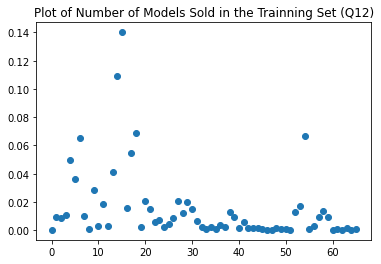

In [12]:
# Visualize the training targets
### START CODE HERE ###
print("The shape of the trainning features is: ", train_X.shape)
print("The shape of the trainning target is: ", train_Y.shape)

print("\nThe first 3 rows of the trainning features are: \n\n", train_X[0:3,:])
print("\nThe trainning targets are (Count of models sold in Q12): \n\n", train_Y[:,-1])

print("\n\n ")

plt.scatter(range(len(train_X[:,-1])), train_Y)
plt.title("Plot of Number of Models Sold in the Trainning Set (Q12)")
plt.show()
### END CODE HERE ###

The shape of the trainning features is:  (71, 74)
The shape of the trainning target is:  (71, 1)

The first 3 rows of the testing features are: 

 [[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
  0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
  0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0]]

The testing targets are (Count of models sold in Q34): 

 [0.00750075 0.0060006  0.01545155 0.04785479 0.01935194 0.05475548
 0.0079508  0.07515752 0.0030003  0.00120012 0.00435044 0.02490249
 0.00990099 0.01875188 0.0259526  0.0379538  0.07290729 0.08565857
 0.00465047 0.01290129 0.02550255 0.03705371 0.02640264 0.05535554
 0.00765077 0.01005101 0.00120012 0.00210021 0.00990099 0.00

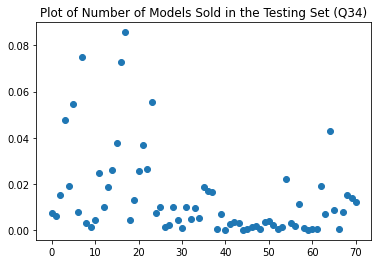

In [13]:
# Visualize the test targets
### START CODE HERE ###
print("The shape of the trainning features is: ", test_X.shape)
print("The shape of the trainning target is: ", test_Y.shape)

print("\nThe first 3 rows of the testing features are: \n\n", test_X[0:3,:])
print("\nThe testing targets are (Count of models sold in Q34): \n\n", test_Y[:,-1])

print("\n\n")

plt.scatter(range(len(test_X[:,-1])), test_Y)
plt.title("Plot of Number of Models Sold in the Testing Set (Q34)")
plt.show()
### END CODE HERE ###

# Task III: Apply Gradient Descent (Linear, Polynomial)

Initialize the $\theta$ parameters as a column vector of zeros, one for every feature in the training data plus one for bias. 

Also set hyperparameters for learning rate and maximum number of iterations through the training data.

In [14]:
# Initialize learned parameters theta and hyperparameters
s_theta = np.zeros((train_X.shape[1]+1, 1))
s_learning_rate = 0.001
#s_learning_rate = 0.01
s_max_iteration = 1000
#s_max_iteration = 2000

### Hypothesis Function

Define your hypothesis function $h$ (which you use to make predictions $\hat{Y}$ as the matrix product of your features data X and parameters theta, in that order. 

Don't forget to add a 0th column of ones to X to account for the bias/offset parameter.

In [16]:
# Define your hypothesis function according to the instructions above
def h (theta, X) :
    ### START CODE HERE ###
    
    # Using numpy insert method to add a column of ones as the first column of X
    tempX = np.insert(X, 0, np.ones((X.shape[0])), axis = 1)
    
    return np.matmul(tempX, theta)
    ### END CODE HERE ###

Define your loss function as **half** the MSE (mean squared error) between your actual and predicted Y values. 

Recall that the predicted Y values are a function of theta and X.


In [17]:
# Loss Function
def loss (theta, X, Y) :
    ### START CODE HERE ###
    
    # Here I'm using the function "h" (Hypothesis) that we created above in order to predict Y
    
    return 0.5 * np.sum(np.square(h(theta, X) - Y)) / X.shape[0]
    
    ### END CODE HERE ###

### Gradient of Hypothesis Function

One can verify through straightforward (if somewhat tedious) multivariable calculus that the gradient of the loss function $J$ with respect to the parameters $\theta$ is 

$$ \frac{\partial J}{\partial \theta} = - \frac{1}{m} X^T \cdot (Y - \hat{Y})$$.

Here, $X$ has been augmented with a bias column. 

Set up a function to compute this gradient.

In [18]:
def gradient (theta, X, Y) :
    ### START CODE HERE ###
    
    # Create a temporary X array with an added 0th bias column
    
    tempX = np.insert(X, 0, np.ones((X.shape[0])), axis = 1)
    
    # Compute the gradient according to the instructions above

    # Once again, I'm using the function "h" (Hypothesis) that we created above in order to predict Y
    # We just need to be careful and pass X as an argument of "h" and not tempX
    
    d_theta = - np.dot(tempX.T, Y - h(theta, X)) / X.shape[0]
    
    ### END CODE HERE ###
    return d_theta

### Gradient Descent

Set up a function to train your linear regression model with gradient descent, i.e. calculate $\frac{\partial J}{\partial \theta}$ and update $\theta$. Recall that the general gradient descent update formula is $\theta := \theta - \alpha \frac{\partial J}{\partial \theta}$. We've provided the skeleton of a stochastic gradient descent function, but you're welcome to experiment with batch and/or minibatch gradient descent. Also recall that the aforementioned gradient descent methods differ in how frequently they calculate $\frac{\partial J}{\partial \theta}$ and update $\theta$. 

In [19]:
def stochastic_gradient_descent (theta, X, Y, learning_rate, max_iteration, gap) :
    ### START CODE HERE ###
    # Initialize the cost as an array of zeros, one for each iteration through the dataset
    cost = np.zeros(max_iteration)
    # Loop over the iterations
    for i in range(max_iteration):
        # Loop over each row in the dataset
        for j in range(X.shape[0]):
            # Compute the gradient from the current row in X and the associated Y value
            # Make sure that both X and Y are represented as 2D row vectors
            d_theta = gradient(theta, X[[j], :], Y[[j], :])
            # Update theta
            theta = theta - learning_rate * d_theta
        # Update the cost array for the current iteration
        cost[i] = loss(theta, X, Y)
    ### END CODE HERE ###
        if i % gap == 0 :
            print ('iteration : ', i, ' loss : ', loss(theta, X, Y)) 
    return theta, cost

In [20]:
s_theta, s_cost = stochastic_gradient_descent(s_theta, train_X, train_Y, s_learning_rate, s_max_iteration, 100)

iteration :  0  loss :  0.0004206533214992532
iteration :  100  loss :  0.0002422983467552357
iteration :  200  loss :  0.00021788868167880288
iteration :  300  loss :  0.00020533288342740926
iteration :  400  loss :  0.00019779653985861766
iteration :  500  loss :  0.00019286413605363375
iteration :  600  loss :  0.00018942848046269562
iteration :  700  loss :  0.00018691690844249828
iteration :  800  loss :  0.00018500756875786405
iteration :  900  loss :  0.00018350797029438473


### Generate Predictions from Test Data

In [21]:
### START CODE HERE ###
GD_P = h(s_theta, test_X)
### END CODE HERE ###
# Set any negative predictions to 0
GD_P[GD_P<0] = 0

### Visualize the predicted and actual test labels

RMSE, R2 using SGD= 0.0005189242294533941 0.6939013195958599
R2 calculated using sklearn =  -0.4961363083514261


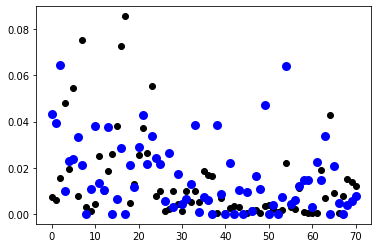

In [22]:
plt.scatter(range(len(test_Y)), test_Y,  color='black')
plt.scatter(range(len(GD_P)), GD_P, color='blue', linewidth=3)
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

# This function evaluates the R**2 statistic
# Source: https://stackoverflow.com/questions/893657/how-do-i-calculate-r-squared-using-python-and-numpy
def r2(Yt,Yp):
    yhat = Yp                         
    ybar = np.sum(Yt)/len(Yt)          
    ssreg = np.sum((yhat-ybar)**2)   
    sstot = np.sum((Yt - ybar)**2)    
    results = ssreg / sstot
    return results


print("RMSE, R2 using SGD=", MSE(test_Y,GD_P), r2(test_Y,GD_P))
print("R2 calculated using sklearn = ", r2_score(test_Y, GD_P))

# Task IV: Normal Equations

Since our training dataset isn't very large, let's generate predictions using the normal equations: 

$$W = (X^T \cdot X)^{-1} \cdot X^T \cdot Y$$ 
$$\hat{Y} = X \cdot W$$

and see how they compare to the predictions which we obtained from gradient descent.
Ensure $$Y=[nx1], W=[dx1], X[nxd]$$ dimensions, respectively.

In [23]:
### START CODE HERE ###
# Just to be completely clear, we are calculating the W matrix using the
# trainning data but we'll calculate our prediction on the testing data

# Compute the inverse of the matrix product of the transpose of X and X
inv1 = np.linalg.pinv(np.dot(train_X.T, train_X))

# Compute W using the first of the Normal Equations
W1 = np.dot(inv1, np.dot(train_X.T, train_Y))

# Compute the predicted Y values using the second of the Normal Equations
# Here we use the testing data 

PN1 = np.dot(test_X, W1)

### END CODE HERE ###

# Set any negative predictions to 0
PN1[np.where(PN1<0)]=0

RMSE, R2 for prediction all features = 0.0005596570062877876 0.8479142625775206
R2 calculated using sklearn =  -0.6135750073038815


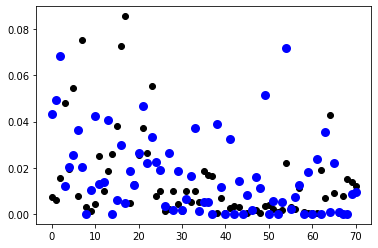

In [24]:
# Plot outputs
plt.scatter(range(len(test_Y)), test_Y,  color='black')
plt.scatter(range(len(PN1)), PN1, color='blue', linewidth=3)
print("RMSE, R2 for prediction all features =", MSE(test_Y,PN1), r2(test_Y,PN1)) #[Low error high corr]
print("R2 calculated using sklearn = ", r2_score(test_Y, PN1))

### Regularized Normal Equations

In [25]:
print('Recall that our training features array train_X has')
print(f'm = {train_X.shape[0]} rows and n = {train_X.shape[1]} columns')

Recall that our training features array train_X has
m = 66 rows and n = 74 columns


`train_X` is thus wider than it is tall, which suggests that the regularized normal equations might perform better in generating label predictions. In this case, we modify the first of the normal equations given above to 

$$W = (X^T \cdot X + \lambda m I)^{-1} \cdot X^T \cdot Y$$.

Here, $\lambda$ is the regularization parameter and $m$ is the number of rows in $X$.

### Repeat the previous parts of Task IV, but this time incorporate regularization

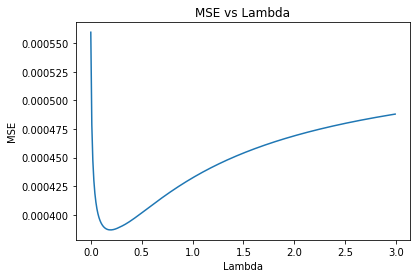

The lowest MSE is 0.0003866990462355009 for lambda =  0.19




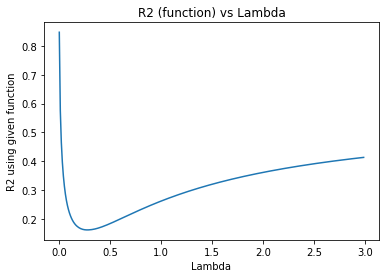

The highest R2 is 0.8479142625775206 for lambda =  0.0




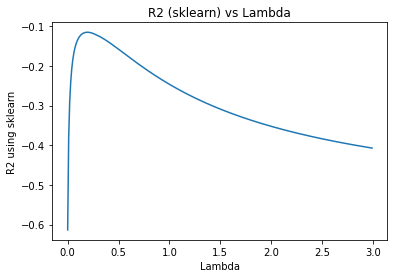

The highest R2 is -0.1149112927087963 for lambda =  0.19


Choosing lambda based on the lowest MSE -> lambda = 0.19

MSE, R2 (using given function), R2 (using sklearn) for prediction all features = 0.0003866990462355009 0.16965113814776805 -0.1149112927087963


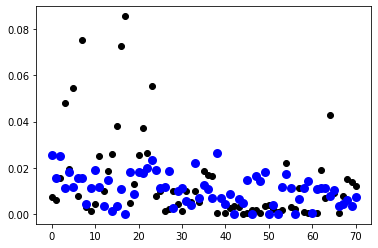

In [60]:
### START CODE HERE ###

# Again, to be completely clear, we are calculating the W matrix using the
# trainning data but we'll calculate our prediction on the testing data


# lambd_arr is an array of different values for the regulization parameter lambda
# m is the number of examples in X
# mse_arr is an array that stores the calculated mse for different values of lambda
# r2_arr is an array that stores the calculated r2 using the given r2 function for different values of lambda
# r2_sklearn_arr is an array that stores the calculated r2 using sklearn for different values of lambda

lambd_arr = np.arange(0, 3, 0.01)
m = train_X.shape[0]
mse_arr = []
r2_arr = []
r2_sklearn_arr = []

# Loop over different values of lambda

for lambd in lambd_arr:

  # Compute the inverse of the matrix product of the transpose of X and X
  # lambd is the regulization parameter and m is the number of examples in X

  inv1 = np.linalg.pinv(np.dot(train_X.T, train_X) + lambd * m * np.identity(train_X.shape[1]))

  # Compute W using the first of the Normal Equations
  W1 = np.dot(inv1, np.dot(train_X.T, train_Y))

  # Compute the predicted Y values using the second of the Normal Equations
  # Here we use the testing data 

  PN2 = np.dot(test_X, W1)

  # Set any negative predictions to 0
  PN2[np.where(PN2<0)]=0
  
  # Calculate current MSE and store in mse_arr
  mse_arr.append(MSE(test_Y, PN2))

  # Calculate current r2 using the given r2 function and store in r2_arr
  r2_arr.append(r2(test_Y, PN2))

  # Calculate current r2 using sklearn and store in r2_sklearn_arr
  r2_sklearn_arr.append(r2_score(test_Y, PN2))

#Plot MSE for different values of lambda

plt.plot(lambd_arr, mse_arr)
plt.xlabel("Lambda")
plt.ylabel("MSE")
plt.title("MSE vs Lambda")
plt.show()

print(f"The lowest MSE is {min(mse_arr)} for lambda = ", lambd_arr[mse_arr.index(min(mse_arr))])
print("\n")

#Plot r2 using the given r2 function for different values of lambda

plt.plot(lambd_arr, r2_arr)
plt.xlabel("Lambda")
plt.ylabel("R2 using given function")
plt.title("R2 (function) vs Lambda")
plt.show()

print(f"The highest R2 is {max(r2_arr)} for lambda = ", lambd_arr[r2_arr.index(max(r2_arr))])
print("\n")

#Plot r2 using sklearn for different values of lambda

plt.plot(lambd_arr, r2_sklearn_arr)
plt.xlabel("Lambda")
plt.ylabel("R2 using sklearn")
plt.title("R2 (sklearn) vs Lambda")
plt.show()

print(f"The highest R2 is {max(r2_sklearn_arr)} for lambda = ", lambd_arr[r2_sklearn_arr.index(max(r2_sklearn_arr))])
print("\n")

# Choosing lambda based on the lowest MSE -> lambda = 0.19
print("Choosing lambda based on the lowest MSE -> lambda = 0.19\n")

lambd = 0.19
inv1 = np.linalg.pinv(np.dot(train_X.T, train_X) + lambd * m * np.identity(train_X.shape[1]))
W1 = np.dot(inv1, np.dot(train_X.T, train_Y))
PN2 = np.dot(test_X, W1)
PN2[np.where(PN2<0)]=0

# Plot outputs
plt.scatter(range(len(test_Y)), test_Y,  color='black')
plt.scatter(range(len(PN2)), PN2, color='blue', linewidth=3)
print("MSE, R2 (using given function), R2 (using sklearn) for prediction all features =", MSE(test_Y,PN2), r2(test_Y,PN2), r2_score(test_Y, PN2))

### END CODE HERE ###

# Task V: Non-linear Regression Models (GLM, DT) 

### Generalized Linear Models

`sm` (our alias for `statsmodels.api`) contains a `GLM` class. Use it to instantiate a model. The relevant parameters are training labels, training features, and `ffamily`, i.e. the family of distributions to which we assume our prediction errors belong. Some potentially good choices for `ffamily` include Gaussian, Gamma, and Logit.

In [26]:
# GLM 
import statsmodels.api as sm
### START CODE HERE ###

# Instantiate the GLM
# GAMMA

# When assuming a gamma distribution for our dependent variable we have to choose
# the right link function, in this case the log function
# We also have to pass train_X with the add 0th columns of ones (intercept) because
# according to the documentation: "an intercept is not included by default and should be added by the user".

glm_gamma = sm.GLM(train_Y, np.insert(train_X, 0, np.ones((train_X.shape[0])), axis = 1), family = sm.families.Gamma(sm.families.links.log))

# Train the GLM
glm_results = glm_gamma.fit()

### END CODE HERE ###
print(glm_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  del sys.path[0]


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   66
Model:                            GLM   Df Residuals:                       34
Model Family:                   Gamma   Df Model:                           31
Link Function:                    log   Scale:                          1.1532
Method:                          IRLS   Log-Likelihood:                 264.99
Date:                Wed, 09 Jun 2021   Deviance:                       52.102
Time:                        15:32:00   Pearson chi2:                     39.3
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.2380      0.409    -10.358      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


### Generate predictions from the test data

In [29]:
### START CODE HERE ###

# Here we also have to add the 0th column to test_X

G_P = glm_results.predict(np.insert(test_X, 0, np.ones((test_X.shape[0])), axis = 1))

### END CODE HERE ###
# Set any negative predictions to 0
G_P[G_P<0]=0

MSE, R2 (using given fuction), R2 (using sklearn) for GLM= 0.0011076205729206145 2.314728951624891 -2.1934360759548475


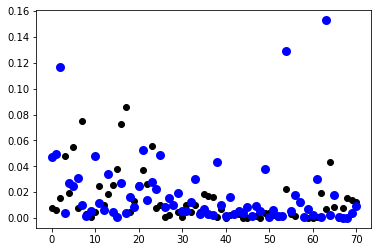

In [30]:
# Plot outputs
plt.scatter(range(len(test_Y)), test_Y,  color='black')
plt.scatter(range(len(G_P)), G_P, color='blue', linewidth=3)
print("MSE, R2 (using given fuction), R2 (using sklearn) for GLM=", MSE(test_Y,G_P), r2(test_Y,G_P), r2_score(test_Y, G_P)) 

### Random Forest Regression

Use the `RandomForestRegressor` from `sklearn.ensemble` to generate predictions. The relevant parameters are the `max_depth` of the trees and the `random_state`, to ensure reproducibility.

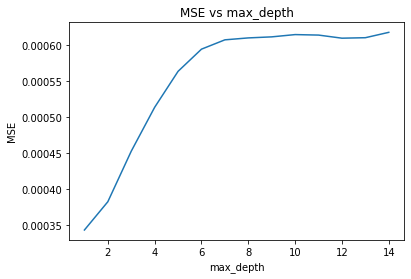

The lowest MSE is 0.00034365230583599776 for max_depth =  1




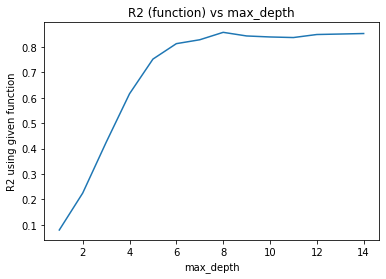

The highest R2 is 0.8575115336319276 for max_depth =  8




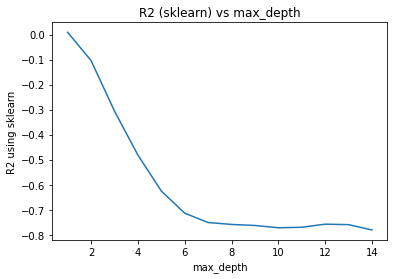

The highest R2 is 0.009198909922740306 for max_depth =  1


Choosing max_depth based on the lowest MSE -> max_depth = 1



In [65]:
### START CODE HERE ###
from sklearn.ensemble import RandomForestRegressor

# I'll add a for loop to search for the best max_depth, the one that yields the lowest MSE

max_depth_rf = range(1, 15)
mse_rf_arr = []
r2_rf_arr = []
r2_rf_sklearn_arr = []

for i in max_depth_rf:

  # Instantiate the random forest regression model
  regr = RandomForestRegressor(max_depth = i, random_state = 10)
  # Train the model
  regr.fit(train_X, train_Y[:,0])
  # Generate predictions from the test data
  pred_rf = regr.predict(test_X)

  # Calculate current MSE and store in mse_arr
  mse_rf_arr.append(MSE(test_Y, pred_rf))

  # Calculate current r2 using the given r2 function and store in r2_arr
  r2_rf_arr.append(r2(test_Y, pred_rf))

  # Calculate current r2 using sklearn and store in r2_sklearn_arr
  r2_rf_sklearn_arr.append(r2_score(test_Y, pred_rf))

#Plot MSE for different values of max_depth

plt.plot(max_depth_rf, mse_rf_arr)
plt.xlabel("max_depth")
plt.ylabel("MSE")
plt.title("MSE vs max_depth")
plt.show()

print(f"The lowest MSE is {min(mse_rf_arr)} for max_depth = ", max_depth_rf[mse_rf_arr.index(min(mse_rf_arr))])
print("\n")

#Plot r2 using the given r2 function for different values of max_depth

plt.plot(max_depth_rf, r2_rf_arr)
plt.xlabel("max_depth")
plt.ylabel("R2 using given function")
plt.title("R2 (function) vs max_depth")
plt.show()

print(f"The highest R2 is {max(r2_rf_arr)} for max_depth = ", max_depth_rf[r2_rf_arr.index(max(r2_rf_arr))])
print("\n")

#Plot r2 using sklearn for different values of max_depth

plt.plot(max_depth_rf, r2_rf_sklearn_arr)
plt.xlabel("max_depth")
plt.ylabel("R2 using sklearn")
plt.title("R2 (sklearn) vs max_depth")
plt.show()

print(f"The highest R2 is {max(r2_rf_sklearn_arr)} for max_depth = ", max_depth_rf[r2_rf_sklearn_arr.index(max(r2_rf_sklearn_arr))])
print("\n")

# Choosing max_depth based on the lowest MSE -> max_depth = 1
print("Choosing max_depth based on the lowest MSE -> max_depth = 1\n")

# Instantiate the random forest regression model
regr = RandomForestRegressor(max_depth = 1, random_state = 10)
# Train the model
regr.fit(train_X, train_Y[:,0])
# Generate predictions from the test data
pred_rf = regr.predict(test_X)

### END CODE HERE ###

In [66]:
# Set any negative predictions to 0
pred_rf[np.where(pred_rf<0)]=0

MSE, R2 (using given fuction), R2 (using sklearn) for Decision Trees= 0.00034365230583599776 0.0795440437728114 0.009198909922740306


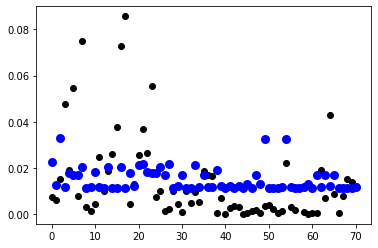

In [67]:
# Plot outputs
plt.scatter(range(len(test_Y)), test_Y,  color='black')
plt.scatter(range(len(pred_rf)), pred_rf, color='blue', linewidth=3)
print("MSE, R2 (using given fuction), R2 (using sklearn) for Decision Trees=", MSE(test_Y,pred_rf), r2(test_Y,pred_rf), r2_score(test_Y,pred_rf))

## Populate the table below with the results of your experiments above. Which models performed best?

## Results shown on the cell below

In [61]:
!pip install tabulate
from tabulate import tabulate

results = [['Method', 'MSE', 'R2 (given function)', 'R2 (sklearn)'], 
           ['Gradient Descent', MSE(test_Y,GD_P), r2(test_Y,GD_P), r2_score(test_Y,GD_P)],
           ['Normal Equations', MSE(test_Y,PN1), r2(test_Y,PN1), r2_score(test_Y,PN1)],
           ['Regularized Normal Equations (lambda = 0.19)', MSE(test_Y,PN2), r2(test_Y,PN2), r2_score(test_Y,PN2)],
           ['GLM', MSE(test_Y,G_P), r2(test_Y,G_P), r2_score(test_Y,G_P)],
           ['Decision Trees (max_depth = 1)', MSE(test_Y,pred_rf), r2(test_Y,pred_rf), r2_score(test_Y,pred_rf)]]

print("\n")
print(tabulate(results, headers = 'firstrow'))



Method                                                MSE    R2 (given function)    R2 (sklearn)
--------------------------------------------  -----------  ---------------------  --------------
Gradient Descent                              0.000518924               0.693901     -0.496136
Normal Equations                              0.000559657               0.847914     -0.613575
Regularized Normal Equations (lambda = 0.19)  0.000386699               0.169651     -0.114911
GLM                                           0.00110762                2.31473      -2.19344
Decision Trees (max_depth = 1)                0.000343652               0.079544      0.00919891


**By looking at the results it seems that the Decision Trees (with max_depth = 1) has the lowest Mean Squared Error (MSE) and the Regularized Normal Equations (with lambda = 0.19) is a close second.**

**If we were to consider only the R2 (given function - the function that was given on the assignment) we would have chosen the Normal Equations method which doesn't make much sense since it's the model that has the highest MSE of all.**

**After spending some time trying to understand why the R2 function was returning some weird results I decided to use r2_score from sklearn api to check and the results were even more strange, basically all methods have negative R2 scores, only the Decision Trees has a marginally positive score, and if you check the scatter plot for the Decision Tree method (with max_depth = 1) you can easily see that it's actually predicting very close to the mean of our trainning set (as expected for such a small max_depth) which explains the r2_score (sklearn) close to 0.**

**To me this shows that perhaps we are in a case where our data does not explain our target at all (they come from different distribuitions), justifying the negative R2 scores (sklearn). This might actually be the case since Q12 has some  different car models than Q34 (as seen on the Set Theory part of the assignment) and the sales patterns might be considerly different. Ideally we should predict for Q34-2019 using perhaps data from other Q34 (2018, 2017...) and not data from Q12.**

**Given that, I guess there's no need to develop any further discussions because my best model (Decision Trees) is doing no better than predicting the mean. There are lots of car models that are been under and over predict. Any adjustment to increase the complexity of the model (higher max_depth for Decision Trees) also increases the MSE.**





## Finally, pick some car types for which your models over- and under-predicted sales. Attempt to determine the root causes. Write your findings below.

# **Summary and Discussion:** **Discuss** "What would you report back as best model for prediction?" 
# Think in terms of Data, Process and Outcomes specifically.
## Consider the following:
1. Can you process the data in some other way? 
2. Given a new data set on the job, how would you report the best "method"? What are the steps to always follow? 
3. What is the metric/metrics you would use to report your results?

#Share screen and discuss findings. Think about generalizability (something that works across data sets)